In [27]:
import pandas as pd
import xarray as xr
import numpy as np
import sys

sys.path.append('/home/users/jamd1/Isca/')
from isca_tools import cesm
from isca_tools.utils import area_weighting, lat_lon_rolling, print_ds_var_list, set_attrs
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g
import isca_tools
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import matplotlib
from matplotlib.dates import ConciseDateConverter
matplotlib.units.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()  # to allow plotting time as x axis
# plt.style.use('/home/users/jamd1/Isca/jobs/publish.mplstyle')
import os
from numba import jit
from geocat.comp.interpolation import interp_hybrid_to_pressure
print(os.getcwd())

/home/users/jamd1/Isca


In [57]:
var_keep = ['P0', 'hyam', 'hybm', 'PS', 'TREFHT', 'QREFHT', 'T', 'Z3']
ds = cesm.load_dataset('e.e20.E1850TEST.f09_g17.daily_output', hist_file=1, year_files=50)[var_keep]

In [10]:
@jit
def _at_txx_ufunc(t2m,y):
    return y[np.argmax(t2m)]


def xr_of_txx(t2m,y): # Find the level of a variable on the annual hottest day for each location
    return xr.apply_ufunc(_at_txx_ufunc, t2m, y,
                             input_core_dims=[['time'],['time']],
                            dask ='parallelized',
                            vectorize=True,
                            output_dtypes=[y.dtype])

In [49]:
temp_profile_xx = xr_of_txx(ds.TREFHT, ds.T).compute()
z_profile_xx = xr_of_txx(ds.TREFHT, ds.Z3).compute()
PS_xx = xr_of_txx(ds.TREFHT, ds.PS).compute()
QREFHT_xx = xr_of_txx(ds.TREFHT, ds.QREFHT).compute()

In [58]:
QREFHT_xx = xr_of_txx(ds.TREFHT, ds.QREFHT).compute()

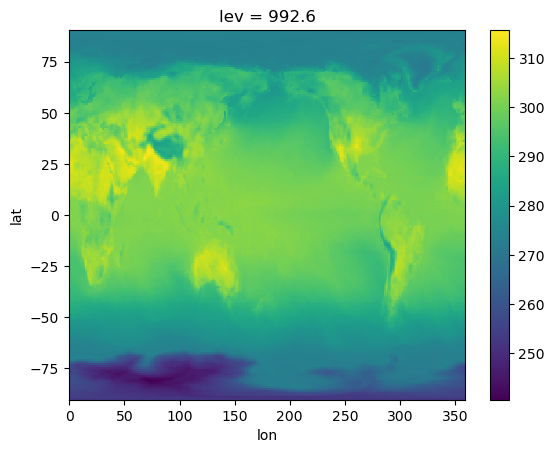

In [66]:
temp_profile_xx.sel(lev=np.inf, method='nearest').plot()

In [59]:
p0 = float(ds.P0[0])
pressure_xx = cesm.get_pressure(PS_xx, p0, hya=ds.hyam.isel(time=0), hyb=ds.hybm.isel(time=0))
mse_sat_xx = moist_static_energy(temp_profile_xx, sphum_sat(temp_profile_xx, pressure_xx), z_profile_xx)
mse_xx = moist_static_energy(temp_profile_xx, QREFHT_xx, z_profile_xx)

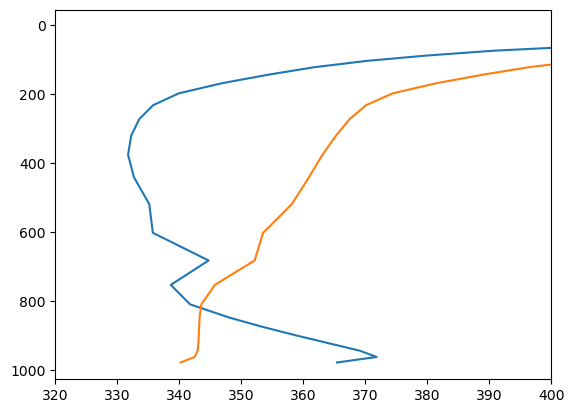

In [74]:
lat_plot = 44
lon_plot = 275
plt.plot(mse_sat_xx.sel(lat=lat_plot, lon=lon_plot, method='nearest'),
         pressure_xx.sel(lat=lat_plot, lon=lon_plot, method='nearest')/100)
plt.plot(mse_xx.sel(lat=lat_plot, lon=lon_plot, method='nearest'),
         pressure_xx.sel(lat=lat_plot, lon=lon_plot, method='nearest')/100)
plt.xlim(320, 400)
plt.gca().invert_yaxis()

In [78]:
ds_use = ds.sel(lat=lat_plot, lon=lon_plot, method='nearest').load()

In [82]:
ds_use['mse'] = moist_static_energy(ds_use.T, ds_use.QREFHT, ds_use.Z3)
ds_use['pressure'] = cesm.get_pressure(ds_use.PS, p0, hya=ds.hyam.isel(time=0), hyb=ds.hybm.isel(time=0))
ds_use['mse_sat'] = moist_static_energy(ds_use.T, sphum_sat(ds_use.T, ds_use.pressure), ds_use.Z3)

In [80]:
ds_use.TREFHT.argmax()

<xarray.DataArray 'TREFHT' ()> Size: 8B
array(188)
Coordinates:
    lat      float64 8B 43.82
    lon      float64 8B 275.0

In [96]:
ds_use.mse.sel(lev=np.inf, method='nearest').argmax()

<xarray.DataArray 'mse' ()> Size: 8B
array(179)
Coordinates:
    lat      float64 8B 43.82
    lon      float64 8B 275.0
    lev      float64 8B 992.6

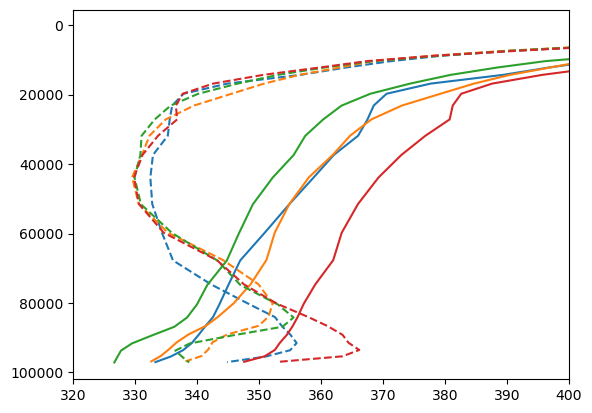

In [99]:
time_ind_plot = int(ds_use.mse.sel(lev=np.inf, method='nearest').argmax())
for i in range(time_ind_plot-3, time_ind_plot+1):
    plt.plot(ds_use.mse_sat.isel(time=i), ds_use.pressure.isel(time=i), linestyle='--', color=f"C{i-(time_ind_plot-3)}")
    plt.plot(ds_use.mse.isel(time=i), ds_use.pressure.isel(time=i), color=f"C{i-(time_ind_plot-3)}")
plt.xlim(320, 400)
plt.gca().invert_yaxis()

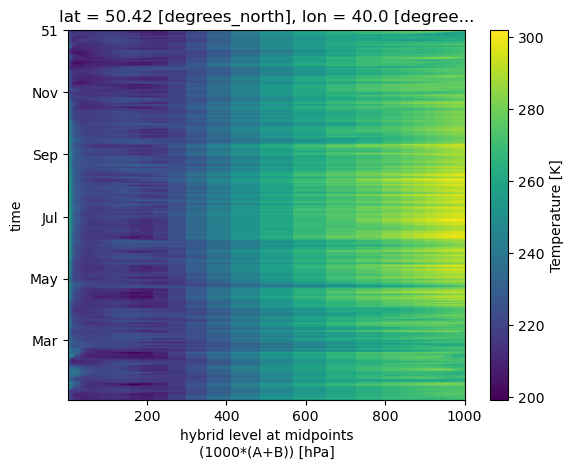

In [12]:
year_files = '41:42'
var_surf = ['TREFHT', 'QREFHT', 'PS']
ds_surf = cesm.load_dataset('test', hist_file=1, month_files=None, year_files=year_files)[var_surf]

In [13]:
ds_land = cesm.load_dataset('test', hist_file=1, month_files=None, comp='lnd', year_files=year_files)[['SOILLIQ']]
ds_land = ds_land.sum(dim='levsoi')
ds_land = ds_land.reindex_like(ds_surf['PS'], method="nearest", tolerance=0.01)

In [14]:
archive_dir = '/gws/nopw/j04/global_ex/jamd1/cesm/CESM2.1.3/archive/'
exp_name = 'test'
plev_dir = 'pressure_levels/TZ_500'
plev_path = os.path.join(archive_dir, exp_name, plev_dir)
os.listdir(plev_path)

['0041.nc', '0042.nc', '0043.nc']

In [15]:
# Each file within directory is just the year (with 4 digits) followed by .nc
year_files_all = [int(var.replace('.nc','')) for var in os.listdir(plev_path) if '.nc' in var]
# Get all years in files which are requested
year_req = isca_tools.utils.base.parse_int_list(year_files, format_func=lambda x: int(x), all_values=year_files_all)
year_req_final = [year_files_all[i] for i in range(len(year_files_all)) if year_files_all[i] in year_req]
# Load in this dataset
ds_plev = xr.open_mfdataset([os.path.join(plev_path, f'{year:04d}.nc') for year in year_req_final])

In [29]:
surf_geopotential_file = '/gws/nopw/j04/global_ex/jamd1/cesm/CESM2.1.3/cesm_inputdata/atm/cam/topo/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
ds_z2m = xr.open_dataset(surf_geopotential_file)[['PHIS']]
ds_z2m['ZREFHT'] = ds_z2m['PHIS'] / g + 2
del ds_z2m['PHIS']

ds_z2m = ds_z2m.reindex_like(ds_surf['PS'], method="nearest", tolerance=0.01)
set_attrs(ds_z2m.ZREFHT, long_name=ds_plev.Z3.long_name, units=ds_plev.Z3.units)
ds_z2m.ZREFHT

<xarray.DataArray 'ZREFHT' (lat: 5, lon: 10)> Size: 400B
array([[2.84197919e+03, 2.87674841e+03, 2.91315379e+03, 2.93361932e+03,
        2.93313907e+03, 2.91118682e+03, 2.87477533e+03, 2.84029100e+03,
        2.82628715e+03, 2.84004700e+03],
       [2.00000000e+00, 2.58515720e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00],
       [2.00000000e+00, 5.59191575e+02, 2.00000000e+00, 6.27186187e+01,
        2.00000000e+00, 2.00017889e+00, 2.00000000e+00, 3.45205270e+01,
        2.00000000e+00, 2.00000000e+00],
       [1.28770498e+02, 1.32412366e+02, 1.11438976e+03, 9.30985770e+02,
        2.00000000e+00, 2.00000000e+00, 9.38009648e+02, 2.30505514e+02,
        2.00000000e+00, 4.79156350e+01],
       [2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
        2.00000000e+00, 2.00000000e+00]])
Coordinates:
  * lat      (lat) float64 40B -90.0 -45.71 -0.4712 44.76 90.0
  * lon      (lon) float64 80B 0.0 38.75 78.75 118.8 ... 238.8 278.8 318.8 358.8
Attributes:
    long_name:  Geopotential Height (above sea level)
    units:      m

In [59]:
ds = xr.merge([ds_surf, ds_land, ds_plev, ds_z2m])

In [85]:
ds_out = xr.load_dataset('/home/users/jamd1/Isca/jobs/cesm/theory_adiabat/above_quant_2m_500hPa/test/output.nd2')